## C12 teambuilding - Simulator tutorial

### Qiskit basics

Qiskit is an open-source framework for working with quantum computers. It is maintained and developed by IBM. It provides tools for creating, manipulating, and simulating quantum circuits and running them on actual quantum computers (IBMQ provider). Qiskit also includes libraries for different quantum algorithms. It has a developed community (available on Slack) and detailed documentation (<a href="https://qiskit.org/documentation/">Qiskit documentation</a>). <br> <br>

The foundation of the Qiskit is module Terra,  which provides the essential tools to build and run quantum circuits. In addition, Terra defines the interfaces for an end-user experience and the layers of optimization, pulse scheduling, and backend communication. The detailed and more comprehensive tutorial can be found <a href="https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html">here</a>.



Aer module has different simulators that can imitate the working quantum computer. We can use Aer to verify that current and near-future quantum computers operate correctly. Aer provides a high-performance simulator framework for quantum circuits using the Qiskit software stack. It contains optimized C++ simulator backends for executing circuits compiled in Terra. Aer also provides tools for constructing highly configurable noise models for performing realistic noisy simulations of the errors that occur during execution on real devices.


To create a quantum circuit, we need to create an instance of the `QuantumCircuit` class and specify the number of qubits.


In [45]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(4) # Create a QuantumCircuit object with 4 qubits

circuit.h(2)     # Add a H (Hadamard) gate on qubit 3
circuit.cx(2, 3) # Add a CX (CNOT) gate on control qubit 3, and target qubit 4
circuit.x(0)     # Add Pauli X gate on the first qubit

circuit.draw() # Visualize the circuit

┌───┐     
q_0: ┤ X ├─────
     └───┘     
q_1: ──────────
     ┌───┐     
q_2: ┤ H ├──■──
     └───┘┌─┴─┐
q_3: ─────┤ X ├
          └───┘

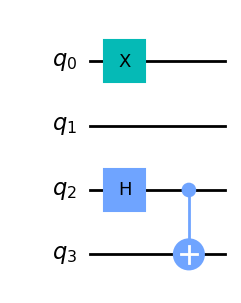

In [46]:
circuit.draw('mpl') # Drawing a circuit using matplotlib (prettier drawing)

### C12 simulator
The C12 simulator is made on top of the Qiskit library with a noise model corresponding to our system integrated to simulate the real machine currently in development.

To run the circuits on the C12 simulator, first, it is mandatory to obtain the authentication token that will be used for connection to the remote server where our simulator is. So don't hesitate to contact the system administrator to get one.

A token is set via UserConfig class, as shown in the example bellow. UserConfig class has other properties, like more detailed out, which can be set by setting the parameter "verbose" to True. One important remark is that the object of the `UserConfig` class is passed to the provider instance, so for any changed to take effect one has to reinitialize the provider.

In [47]:
# Installing the c12simulator-clients package (for more details see jupyter 1)
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple c12simulator-clients==0.0.36 -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


As mentioned in the first tutorial, the provided class contains information about available backends that can be used for running the circuit. Furthermore, the available ones can be viewed using the `backends()` method of the provider class (recall that this applies to every Qiskit's provider class, as its sole purpose is to provide access to backends).


In [48]:
# UserConfig class
from c12simulator_clients.user_configs import UserConfigs
user_auth_token = "db0ccae9b0dfccba90a534ad40802d40aa57d395bdac4e3a0bfcaaa7db0a3c2f"
configs = UserConfigs.parse_obj({"token" : user_auth_token, "verbose" : False})

from c12simulator_clients.qiskit_back.c12sim_provider import C12SimProvider
c12_simulator_provider = C12SimProvider(configs)
c12_backends = c12_simulator_provider.backends()

# See all available backends on the C12 system (basis gates sets).
for backends in c12_backends:
    print(backends)
    print("----------------")

{'backend_name': 'c12sim', 'local': False, 'simulator': True, 'basis_gates': ['crx', 'rx', 'ry', 'rz'], 'description': 'C12 simulator', 'n_qubits': 5, 'conditional': False, 'max_shots': 100000, 'memory': False, 'open_pulse': False, 'max-circuits': 1}
----------------
{'backend_name': 'c12sim-iswap', 'local': False, 'simulator': True, 'basis_gates': ['iswap', 'rx', 'ry', 'rz'], 'description': 'C12 simulator', 'n_qubits': 5, 'conditional': False, 'max_shots': 100000, 'memory': False, 'open_pulse': False, 'max-circuits': 1}
----------------


We have to call the `get_backend()` function to get the instance of a chosen backend. To the `get_backend()` function, we pass the name of the desired backend we need to obtain.


In [49]:
crx_backend =  c12_simulator_provider.get_backend('c12sim')
iswap_backend =  c12_simulator_provider.get_backend('c12sim-iswap')

In [50]:
# It is possible to get a list of all available physical params of the system
from c12simulator_clients.api.client import Request
request = Request(auth_token=user_auth_token, verbose=False)
physical_params = request.get_params()

for key,value in physical_params.items():
    print(f"{key} : {value}")

# B_sym B_asym: Magnetic fields (units: T) 0 Hz < alpha < 10 GHz
# epsilon: Potential difference across the nanotube (units: V)
# half_delta_g: Coupling between the electron and the cavity (units: Hz) 10 MHz < half_delta_g < 300 MHz

# Frequencies (units: Hz)
# 7 MHz < omega_b < 120 MHz bending
# 10 GHz < omega_t < 40 GHz twisting
# 6 GHz < omega_s < 25 GHz stretching

# Coupling between the qubit and the oscillation modes (units: Hz)
# 1e-7 eV < lambda_b < 3e-5 eV
# 1e-8 eV < lambda_t < 1e-7 eV
# 5e-8 eV < lambda_s < 4e-7 eV


# Quality factors (units: none)
# 1e3 < Q_c < 1e4

# Temperature (units: K) :10 mK < T < 20 mK
# Omega_d: Microwave signal amplitude for 1-qubit gates (units: Hz)  < 1 GHz
# 0.02 mu^2  < power_spect_const <  0.1 mu eV^2 (units: GHz^2)

B_sym : 0.245,
B_asym : 0.245,
epsilon : 0.0,
half_delta_g : 300e6,
omega_b : 14.1e6,
omega_t : 19.9e9,
omega_s : 12.3e9,
lambda_nu_b : 1.5e-5 ,
lambda_nu_t : 5.0e-8 ,
lambda_nu_s : 2.0e-7,
Q_c : 1e4,
Q_nu_b : 1e2,
Q_nu_t : 1e5,
Q_nu_s : 1e5,
T : 20e-3,
Omega_d : 500e6,
power_spect_const : 0.00117


Finally, we will run a quantum circuit on the C12 simulator. We will create one circuit using the Qiskit QuantumCircuit class to do that. Then, using the obtained C12 simulator backend class, we will run the circuit using the `run()` method.

Method `run()` can have an additional parameter, such as the number of shots (number of times the simulation is run)
Also, recall that after calling the `run()` method, we get an instance of a Job class.
Additionally, it could take some time for the simulation to finish. Usually, the time is less than one minute, but it depends on the circuit and the server load at that moment.

Fidelities for our gates:

1. <b> RX(pi) </b>: 0.9999022936684131
2. <b> RY(pi) </b>: 0.9999022936684124
3. <b> RZ(pi) </b>: 1.0
4. <b> CRX(pi) </b>: 0.9996257593279184
5. <b> iSWAP </b>: 0.8907042874819673



In [84]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.iswap(0,1)

c12_job = iswap_backend.run(circuit, shots=10000)
c12_result = c12_job.result()
c12_counts = c12_result.get_counts()

TypeError: unsupported operand type(s) for /: 'Counts' and 'float'

In [85]:
print(f"C12  counts: {c12_counts}")

C12  counts: {'11 ': 98, '10 ': 634, '00 ': 8634, '01 ': 634}


In [86]:

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

c12_job_crx = crx_backend.run(circuit, shots=10000)
c12_result_crx = c12_job_crx.result()
c12_counts_crx = c12_result_crx.get_counts()
print(f"C12 CRX simulation counts: {c12_counts_crx}")

C12 CRX simulation counts: {'01 ': 3, '10 ': 3, '00 ': 5003, '11 ': 4991}


In [87]:
c12_job_iswap = iswap_backend.run(circuit, shots=10000)
c12_result_iswap = c12_job_iswap.result()
c12_counts_iswap = c12_result_iswap.get_counts()
print(f"C12 iSWAP simulation counts: {c12_counts_iswap}")

C12 iSWAP simulation counts: {'01 ': 526, '10 ': 792, '00 ': 4231, '11 ': 4451}


In [89]:
# We will also run the same circuit on the Aer statevector simulator to obtain the perfect results.
from qiskit import Aer

backend_aer = Aer.get_backend("statevector_simulator")
result_aer = backend_aer.run(circuit, shots=10000).result()
counts_aer = result_aer.get_counts()

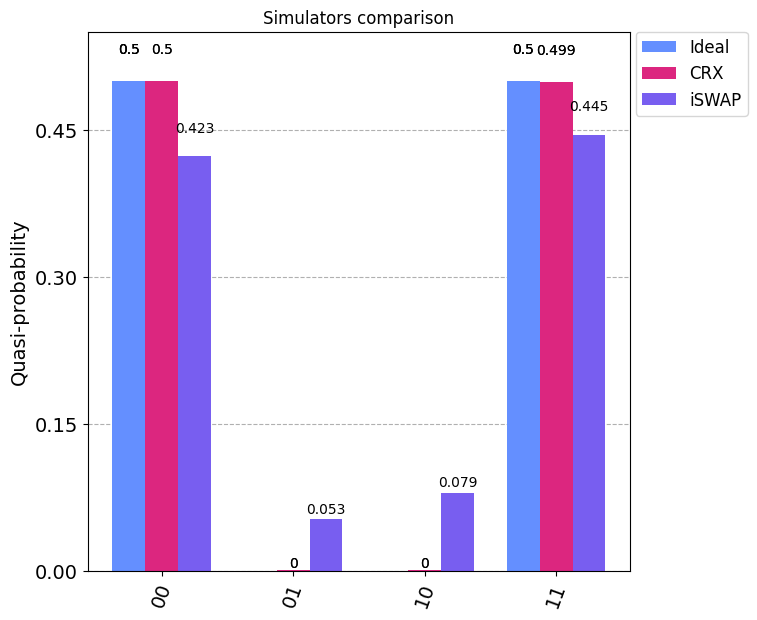

In [90]:
# Make comparison
from qiskit.visualization import plot_histogram
crx = {}
for key, value in c12_counts_crx.items():
    crx[key.strip()] = value
iswap = {}

for key, value in c12_counts_iswap.items():
    iswap[key.strip()] = value

data = [counts_aer, crx, iswap]

plot_histogram(data,
               legend=["Ideal", "CRX", "iSWAP"],
               title="Simulators comparison",
               figsize=(7, 7))

### <b> <u> Exercise (1) </b> </u>:
Run random circuit using our simulator. Try long circuits, a lot of two qubit gates, different gates etc.

C12 test simulation counts: {'01 ': 3, '10 ': 3, '00 ': 5003, '11 ': 4991}


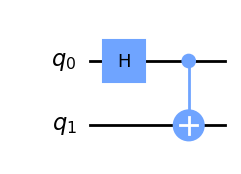

In [91]:
# Also it is possible to retrieve the circuit that has been run for specific job
c12_job = crx_backend.run(circuit, shots=10000)
c12_result_crx = c12_job_crx.result()
c12_counts_crx = c12_result_crx.get_counts()
print(f"C12 test simulation counts: {c12_counts_crx}")

qasm = c12_job.get_qasm() # Get OpenQASM string
first_job_circuit = c12_job.get_circuit()
first_job_circuit.draw('mpl')

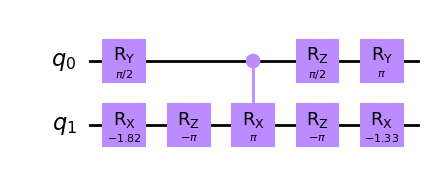

In [92]:
# Getting the transpiled circuit
# NOTICE: It can be possible that due tu bug in Qiskit's transpile function some circuits are wrongly converted to QASM string

first_job_transpiled_qasm = c12_job.get_qasm(transpiled=True) # Get transpiled OpenQASM string
first_job_transpiled_circuit = c12_job.get_circuit(transpiled=True)
first_job_transpiled_circuit.draw('mpl')

### Getting the mid-circuit states

Usually, we only see the final results of the execution of our circuit. However, occasionally it is helpful to know how the state of the system evolves during the execution of the circuit, particularly if we are interested in the statevector and the density matrix of the system.

 It is necessary to state that currently, on the majority of the real quantum computers, it is not possible to get the mid-circuit states (and the measurements also), so this is an excellent functionality for the simulators.

To achieve this, we will use barriers supported by Qiskit and OpenQASM standards. We will get the results of the states of the system at the location where the barrier is placed. Also, it is crucial to notice that the barriers divide the circuit for trnaspilation. Hence, they will behave as a separator for the states and the transpilation process.

First, we will demonstrate the usage of the barriers. Afterward, we will retrieve the desired states at the given time.

In [72]:
from qiskit import QuantumCircuit

# For more info about Qiskit see notebook 1 and the Qiskit's documentation
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.barrier() # We add a barrier at this position
circuit.cx(0, 1)
circuit.barrier()
circuit.x(1)

circuit.draw()
# Notice the barrier position in the circuit

┌───┐ ░       ░      
q_0: ┤ H ├─░───■───░──────
     └───┘ ░ ┌─┴─┐ ░ ┌───┐
q_1: ──────░─┤ X ├─░─┤ X ├
           ░ └───┘ ░ └───┘

In [73]:
# Running the circuit on C12 simulator
c12_job = crx_backend.run(circuit, shots=10000)
c12_result = c12_job.result()
c12_counts = c12_result.get_counts()
print(f"C12 simulation counts: {c12_counts}")

C12 simulation counts: {'11 ': 5, '00 ': 2, '10 ': 4943, '01 ': 5050}


9d71d7f6-a677-4f1f-b242-4ec5bb5f4b8d


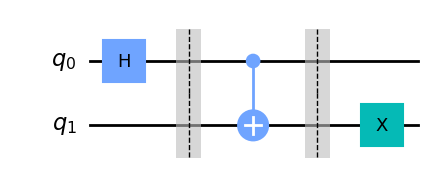

In [74]:
# Get the job_id
job_id = c12_job.job_id()
print(job_id)

# Getting all the data (transpiled circuit mainly)
orig_circuit = c12_job.get_circuit(transpiled=False)
orig_circuit.draw('mpl')

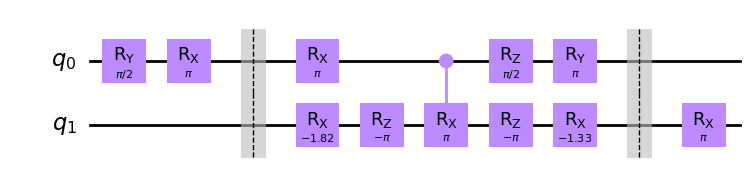

In [75]:
transpiled_circuit = c12_job.get_circuit(transpiled=True)
transpiled_circuit.draw('mpl')

#### Getting the mid-circuit states
The mid-circuit states are stored in the result object obtained from the job execution. The values can be accessed directly from the Result instance using the following command:


 `result_obj.data()['sv{NUM}']` for the state vector
 `result_obj.data()['dm{NUM}']` for the density matrix

The `{NUM}` presents the cardinal number of the barrier starting from one.

In [76]:
# Attention! job is the instance obtained from the search, so it doesn't have any results stored, so we need to call result() function
# see notebook 3 for more information
c12_job.result()
statevector_1 = c12_job.get_mid_statevector(1)
density_matrix_1 = c12_job.get_mid_density_matrix(1)

print(statevector_1)
print(density_matrix_1)

Statevector([0.50001055+0.j, 0.49998945+0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2))
DensityMatrix([[0.50001055+0.00000000e+00j, 0.49987001-1.12970308e-08j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
               [0.49987001+1.12970308e-08j, 0.49998945+0.00000000e+00j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
               [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
               [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j]],
              dims=(2, 2))


### Changing the physical params of the system

In [95]:

# B_sym B_asym: Magnetic fields (units: T) 0 Hz < alpha < 10 GHz
# epsilon: Potential difference across the nanotube (units: V)
# half_delta_g: Coupling between the electron and the cavity (units: Hz) 10 MHz < half_delta_g < 300 MHz

# Frequencies (units: Hz)
# 7 MHz < omega_b < 120 MHz bending
# 10 GHz < omega_t < 40 GHz twisting
# 6 GHz < omega_s < 25 GHz stretching

# Coupling between the qubit and the oscillation modes (units: Hz)
# 1e-7 eV < lambda_b < 3e-5 eV
# 1e-8 eV < lambda_t < 1e-7 eV
# 5e-8 eV < lambda_s < 4e-7 eV


# Quality factors (units: none)
# 1e3 < Q_c < 1e4

# Temperature (units: K) :10 mK < T < 20 mK
# Omega_d: Microwave signal amplitude for 1-qubit gates (units: Hz)  < 1 GHz
# 0.02 mu^2  < power_spect_const <  0.1 mu eV^2 (units: GHz^2)

params = {
    "Omega_d" : 1e2
}

c12_job_test = iswap_backend.run(circuit, shots=10000, physical_params=str(params))
c12_result_test = c12_job_test.result()
c12_counts_test = c12_result_test.get_counts()
print(f"C12 test simulation with param change counts: {c12_counts_test}")


C12 test simulation with param change counts: {'01 ': 2494, '00 ': 2478, '10 ': 2523, '11 ': 2505}


### <b> <u> Exercise (2) </b> </u>:

Try changing the physical parameters of the syste in order to get the better fidelity for the iSWAP gate.